In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
import csv

# Explore the category names

In [3]:
category_data=pd.read_csv("../input/category_names.csv")
print("Total categories are:", len(category_data))

def concat_category_names(row):
    return "|".join([row['category_level1'],row['category_level2'],row['category_level3']])

category_data['category_name'] = category_data.apply(concat_category_names, axis=1)

category_names_df = category_data[['category_id', 'category_name']]
category_names_dict = category_names_df.set_index('category_id').T.to_dict('list')
category_names_dict[1000021794]

Total categories are: 5270


['ABONNEMENT / SERVICES|CARTE PREPAYEE|CARTE PREPAYEE MULTIMEDIA']

# Load the train_example data

In [4]:
# Simple data processing
data = bson.decode_file_iter(open('../input/train_example.bson', 'rb'))

11 ['TELEPHONIE - GPS|ACCESSOIRE TELEPHONE|COQUE TELEPHONE - BUMPER TELEPHONE']
image shape: 
(180, 180, 3)


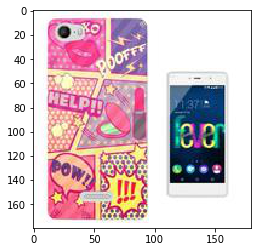

In [15]:
product = next(data)
imgs = product['imgs']
product_id = product['_id']
category_id = product['category_id']
print(product_id, category_names_dict[category_id])
picture=imread(io.BytesIO(imgs[0]['picture']))
plt.imshow(picture)
print("image shape: ")
print(picture.shape)

# Convert bson into tfrecords

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import bson 
import tensorflow as tf
from skimage.data import imread   # or, whatever image library you prefer
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

# helper functions
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)

input_bson_filename = '../input/train_example.bson'
output_tfrecords_filename = '../output/train_example.tfrecords'
# on my workstation it takes about 5 min per 100k entries, so should finish in about 6h
z = 0 
data = bson.decode_file_iter(open(input_bson_filename, 'rb'))
with tf.python_io.TFRecordWriter(output_tfrecords_filename, options=opts) as writer:
    for c, d in enumerate(data):       
        n_img = len(d['imgs'])
        for index in range(n_img):
            img_raw = d['imgs'][index]['picture']
            img = imread(io.BytesIO(img_raw))
            height = img.shape[0]
            width = img.shape[1]
            product_id = d['_id']
            category_id = d['category_id'] 
            example = tf.train.Example(features=tf.train.Features(
                feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'category_id': _int64_feature(category_id),
                'product_id': _int64_feature(product_id),
                'img_raw':_bytes_feature(img_raw)
            }))
            writer.write(example.SerializeToString())
        z = z + 1
        if z % 10000 == 0:
            print(z)
            break

category_names.csv
sample_submission.csv
train_example.bson



In [15]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'category_id': tf.FixedLenFeature([], tf.int64),
        'product_id': tf.FixedLenFeature([], tf.int64),
        'img_raw': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['img_raw'], tf.uint8)    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = features['category_id']
    
    image_shape = tf.stack([height, width, 3])    
    image = tf.reshape(image, image_shape)
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    images, labels = tf.train.shuffle_batch( [resized_image, label],
                                                 batch_size=2,
                                                 capacity=10,
                                                 num_threads=1,
                                                 min_after_dequeue=5)
    return images, labels

In [16]:
filename_queue = tf.train.string_input_producer([output_tfrecords_filename], num_epochs=1)
images, labels = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Let's read off 3 batches just for example
    for i in range(1):
    
        img, anno = sess.run([images, labels])
        print(img[0, :, :, :].shape)
        
#         print('current batch')
        
#         # We selected the batch size of two
#         # So we should get two image pairs in each batch
#         # Let's make sure it is random

#         io.imshow(img[0, :, :, :])
#         io.show()

#         io.imshow(anno[0, :, :, 0])
#         io.show()
        
#         io.imshow(img[1, :, :, :])
#         io.show()

#         io.imshow(anno[1, :, :, 0])
#         io.show()
        
    
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.DataLossError'>, corrupted record at 0
	 [[Node: ReaderReadV2 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/cpu:0"](TFRecordReaderV2, input_producer_1)]]


OutOfRangeError: RandomShuffleQueue '_70_shuffle_batch_6/random_shuffle_queue' is closed and has insufficient elements (requested 2, current size 0)
	 [[Node: shuffle_batch_6 = QueueDequeueManyV2[component_types=[DT_UINT8, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_6/random_shuffle_queue, shuffle_batch_6/n)]]

Caused by op 'shuffle_batch_6', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-70084ab060b5>", line 2, in <module>
    images, labels = read_and_decode(filename_queue)
  File "<ipython-input-15-5e49af4b7aa7>", line 40, in read_and_decode
    min_after_dequeue=5)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/input.py", line 1220, in shuffle_batch
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/input.py", line 791, in _shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/data_flow_ops.py", line 457, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1342, in _queue_dequeue_many_v2
    timeout_ms=timeout_ms, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): RandomShuffleQueue '_70_shuffle_batch_6/random_shuffle_queue' is closed and has insufficient elements (requested 2, current size 0)
	 [[Node: shuffle_batch_6 = QueueDequeueManyV2[component_types=[DT_UINT8, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_6/random_shuffle_queue, shuffle_batch_6/n)]]


In [ ]:
# %load ../conv_mnist.py
"""
Deep MNIST classifier using convolutional layers

Input -> Conv -> Pool -> Conv -> Pool -> FullyConnected -> Dropout -> Softmax
"""

from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os

# Silence compile warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

NO_CLASSES = 10
IMAGE_SIZE = 28
BATCH_SIZE = 100

# Variables:
# - tensor whose value can be changed by running ops on it
# - all variables automatically added to graph collections
# GraphKeys.TRAINABLE_VARIABLES and GraphKeys.GLOBAL_VARIABLES

# tf.Variable() constructor
# - always create a new variable even given the same name, just appends _1, _2
# etc. to variables constrcuted with the same name - can cause conflicts :(
# - requires that an initial value be specified
# - prefixes the name with the current variable or name scope

# tf.get_variable() constructor
# - gets an existing variable with input parameters or create a new one
# - enables variable sharing i.e. reusing previously created variables of the
# same name, making it easy to define models which reuse layers
# - prefixes the name with the current variable scope to perform reuse checks

# Scopes:
# - name_scope will add scope as a prefix to all operations
# - variable_scope will add scope as a prefix to all variables AND
# operations
# Note: when instantiating variables using tf.Variable() constructer,
# name_scope and variable_scope have the same effect, it's just
# tf.get_variable() that ignores name_scope
# Always use tf.variable_scope to define the scope of a shared variable


def _weight_variable(shape):
    return tf.get_variable(name='weights',
                           initializer=tf.truncated_normal(shape, stddev=0.1))


def _bias_variable(shape):
    return tf.get_variable(name='biases',
                           initializer=tf.constant(0.1, shape=shape))


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def _variable_summaries(var, name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar(name + '/mean', mean)
    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar(name + '/stddev', stddev)


def _activation_summaries(x, name):
    tf.summary.scalar(name + '/sparsity', tf.nn.zero_fraction(x))
    tf.summary.histogram(name, x)
    _variable_summaries(x, name)


def _conv2d_layer(layer_name, input_tensor, filter_size, no_filters,
                  act=tf.nn.relu, summaries=False):
    '''
    Implement 2D convolution, non-linearize with ReLU
    '''
    # Add variables and operations to scopes to ensure logical grouping of
    # layers Graph
    with tf.variable_scope(layer_name):
        input_dim = input_tensor.get_shape()[-1].value

        weight = _weight_variable([filter_size, filter_size, input_dim,
                                  no_filters])
        bias = _bias_variable([no_filters])
        preactivate = tf.nn.bias_add(conv2d(input_tensor, weight), bias)
        activation = act(preactivate, "activation")

        if summaries:
            _variable_summaries(weight, '/weights')
            _variable_summaries(bias, '/biases')
            _activation_summaries(activation, 'activations')

        return activation


def _max_pool2d_layer(layer_name, input_tensor, pool_size, stride):
    '''
    Apply 2x2 max pooling
    '''
    with tf.variable_scope(layer_name):
        pooled = tf.nn.max_pool(
            input_tensor, ksize=[1, pool_size, pool_size, 1],
            strides=[1, stride, stride, 1], padding='SAME')
        return pooled


def _fc_layer(layer_name, input_tensor, no_filters, act=tf.nn.relu,
              dropout=None, summaries=False):
    '''
    Flatten input_tensor if needed, non-linearize with ReLU and optionally
    apply dropout
    '''
    with tf.variable_scope(layer_name):
        # Reshape input tensor to flatten tensor if needed
        input_shape = input_tensor.get_shape()
        if len(input_shape) == 4:
            input_dim = np.int(np.product(input_shape[1:]))
            input_tensor = tf.reshape(input_tensor, [-1, input_dim])
        elif len(input_shape) == 2:
            input_dim = input_shape[-1].value
        else:
            raise RuntimeError('Input Tensor Shape: {}'.format(input_shape))

        weight = _weight_variable([input_dim, no_filters])
        bias = _bias_variable([no_filters])
        preactivate = tf.nn.bias_add(tf.matmul(input_tensor, weight), bias)
        activation = act(preactivate, "activation")

        if dropout is not None:
            activation = tf.nn.dropout(activation, dropout)

        if summaries:
            _variable_summaries(weight, '/weights')
            _variable_summaries(bias, '/biases')
            _activation_summaries(activation, '/activations')

        return activation


def inference(images, keep_prob, summaries):
    '''
    Build network graph to compute output predictions for images
    '''
    # Reshape images to 4d tensor
    # [BATCH_SIZE, 784] -> [BATCH_SIZE, width, height, no_color_channels]
    input = tf.reshape(images, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

    out = _conv2d_layer(input_tensor=input, filter_size=5, no_filters=32,
                        layer_name='conv_1', summaries=summaries)
    out = _max_pool2d_layer(input_tensor=out, pool_size=2, stride=2,
                            layer_name='max_pool_1')
    out = _conv2d_layer(input_tensor=out, filter_size=5, no_filters=64,
                        layer_name='conv_2', summaries=summaries)
    out = _max_pool2d_layer(input_tensor=out, pool_size=2, stride=2,
                            layer_name='max_pool_2')
    out = _fc_layer(input_tensor=out, no_filters=1024, dropout=keep_prob,
                    layer_name='fc_1', summaries=summaries)
    logits = _fc_layer(input_tensor=out, no_filters=NO_CLASSES,
                       act=tf.identity, layer_name='fc_2',
                       summaries=summaries)

    return logits


def loss(logits, labels):
    '''
    Calculate cross entropy loss
    '''
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=labels, logits=logits)
    return tf.reduce_mean(cross_entropy, name='loss_op')


def train(loss, learning_rate):
    '''
    Train model by optimizing gradient descent
    Add summary to track loss on TensorBoard
    '''
    # Create gradient descent optimizer with learning rate
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss, name='train_op')
    tf.summary.scalar('loss', loss)
    return train_op


def accuracy(logits, labels):
    '''
    Calculate accuracy of logits at predicting labels
    Add summary to track accuracy on TensorBoard
    '''
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),
                                 name='accuracy_op')
    tf.summary.scalar('accuracy', accuracy_op)
    return accuracy_op


def fill_feed_dict(data, images_pl, labels_pl, keep_prob_pl, keep_prob):
    '''
    Fill feed_dict for training step
    '''
    batch_images, batch_labels = data.next_batch(BATCH_SIZE)
    return {images_pl: batch_images,
            labels_pl: batch_labels,
            keep_prob_pl: keep_prob}


def evaluate(sess, data, images_pl, labels_pl, keep_prob_pl, keep_prob,
             accuracy_op):
    '''
    Evaluate model against data
    '''
    epoch = data.num_examples // BATCH_SIZE
    acc = 0.0
    t0 = time.time()
    for i in range(epoch):
        feed_dict = fill_feed_dict(data, images_pl, labels_pl,
                                   keep_prob_pl, keep_prob)
        acc += sess.run(accuracy_op, feed_dict=feed_dict)

    print(("Epoch Accuracy: {:.4f} [timer: {:.2f}s]")
          .format(acc / epoch, time.time() - t0))
    

